<a href="https://colab.research.google.com/github/pxxxxxxx123446/libsvm/blob/master/HW06/HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - Generative Adversarial Network**



This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.





In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [2]:
!unzip -q "./crypko_data.zip" -d "./crypko_data/"

In [2]:
# You may replace the workspace directory if you want.

workspace_dir = './SA-GAN/outputs/'



# # Training progress bar

# !pip install ipykernel==5.5.6



# !pip install -q qqdm

### Download the dataset

**Please use the link according to the last digit of your student ID first!**



If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).



* To open the file using your browser, use the link below (replace the id first!):

https://drive.google.com/file/d/REPLACE_WITH_ID

* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

###Unzip the downloaded file.

The unzipped tree structure is like

```

faces/

├── 1.jpg

├── 2.jpg

├── 3.jpg

...

```

## Random seed

Set the random seed to a certain value for reproducibility.

In [1]:
import random



import torch

import numpy as np





def same_seeds(seed):

    # Python built-in random module

    random.seed(seed)

    # Numpy

    np.random.seed(seed)

    # Torch

    torch.manual_seed(seed)

    if torch.cuda.is_available():

        torch.cuda.manual_seed(seed)

        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False

    torch.backends.cudnn.deterministic = True



same_seeds(2024)

## Import Packages

First, we need to import packages that will be used later.



Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
pip install qqdm

In [2]:
import os

import glob



import torch.nn as nn

import torch.nn.functional as F

import torchvision

import torchvision.transforms as transforms

from torch import optim

from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from qqdm.notebook import qqdm

## Dataset

1. Resize the images to (64, 64)

1. Linearly map the values from [0, 1] to  [-1, 1].



Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [3]:
class CrypkoDataset(Dataset):

    def __init__(self, fnames, transform):

        self.transform = transform

        self.fnames = fnames

        self.num_samples = len(self.fnames)



    def __getitem__(self,idx):

        fname = self.fnames[idx]

        # 1. Load the image

        img = torchvision.io.read_image(fname)

        # 2. Resize and normalize the images using torchvision.

        img = self.transform(img)

        return img



    def __len__(self):

        return self.num_samples





def get_dataset(root):

    fnames = glob.glob(os.path.join(root, '*'))

    # 1. Resize the image to (64, 64)

    # 2. Linearly map [0, 1] to [-1, 1]

    compose = [

        transforms.ToPILImage(),

        transforms.Resize((64, 64)),

        transforms.ToTensor(),

        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), 

    ]

    transform = transforms.Compose(compose)

    dataset = CrypkoDataset(fnames, transform)

    return dataset

### Show some images

Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


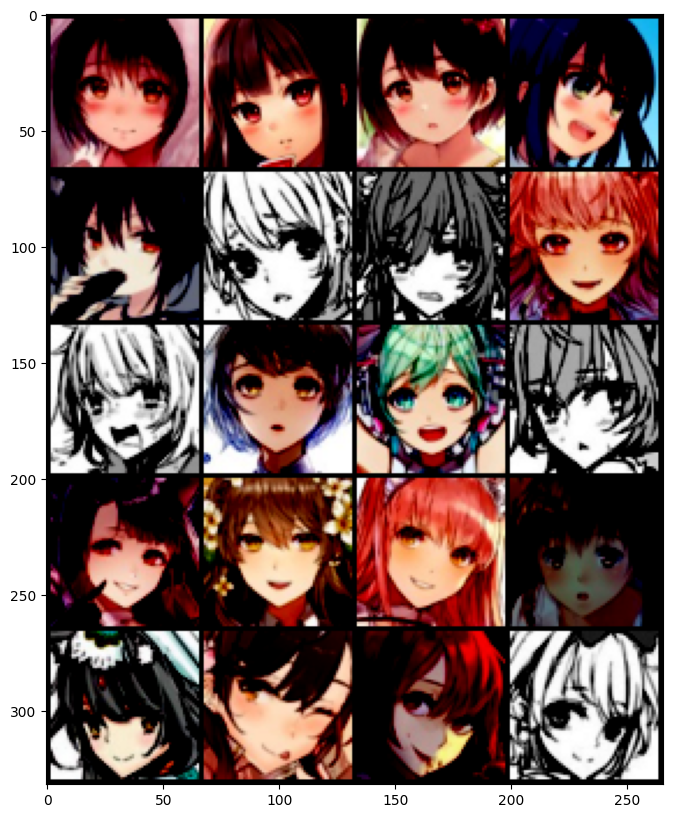

In [4]:

dataset = get_dataset('./crypko_data/faces')


images = [dataset[i] for i in range(20)]

grid_img = torchvision.utils.make_grid(images, nrow=4)

plt.figure(figsize=(10,10))

plt.imshow(grid_img.permute(1, 2, 0))

plt.show()

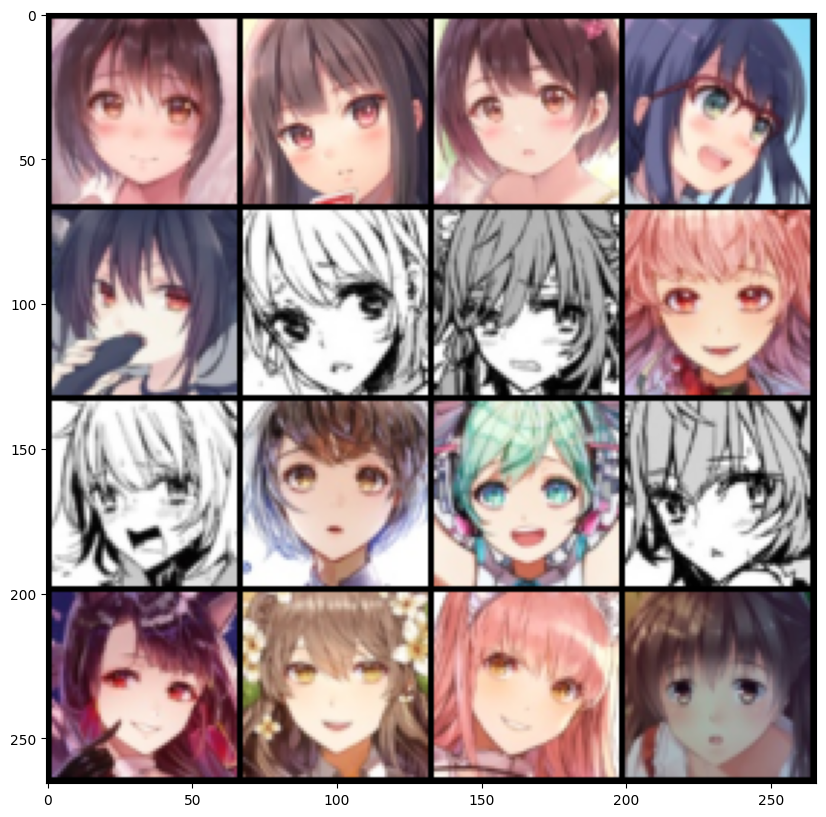

In [5]:
images = [(dataset[i]+1)/2 for i in range(16)]

grid_img = torchvision.utils.make_grid(images, nrow=4)

plt.figure(figsize=(10,10))

plt.imshow(grid_img.permute(1, 2, 0))

plt.show()

## Model

Here, we use DCGAN as the model structure. Feel free to modify your own model structure.



Note that the `N` of the input/output shape stands for the batch size.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from spectral import SpectralNorm
import numpy as np


class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(SpectralNorm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(SpectralNorm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out, p1, p2


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(SpectralNorm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze(), p1, p2

## Training 

### Initialization

- hyperparameters

- model

- optimizer

- dataloader

In [35]:
# training parameters
import argparse
import sys

def str2bool(v):
    return v.lower() in ('true')

def get_parameters():

    if 'ipykernel' in sys.argv[0]:  # 如果在 Jupyter 中运行
        sys.argv = ['']  # 清空 sys.argv
    parser = argparse.ArgumentParser()
    
    # Model hyper-parameters
    parser.add_argument('--model', type=str, default='sagan', choices=['sagan', 'qgan'])
    parser.add_argument('--adv_loss', type=str, default='wgan-gp', choices=['wgan-gp', 'hinge'])
    parser.add_argument('--imsize', type=int, default=64)
    parser.add_argument('--g_num', type=int, default=5)
    parser.add_argument('--z_dim', type=int, default=128)
    parser.add_argument('--g_conv_dim', type=int, default=64)
    parser.add_argument('--d_conv_dim', type=int, default=64)
    parser.add_argument('--lambda_gp', type=float, default=10)
    parser.add_argument('--version', type=str, default='sagan_1')

    # Training setting
    parser.add_argument('--total_step', type=int, default=5000, help='how many times to update the generator')
    parser.add_argument('--d_iters', type=float, default=5)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--num_workers', type=int, default=2)
    parser.add_argument('--g_lr', type=float, default=0.0001)
    parser.add_argument('--d_lr', type=float, default=0.0004)
    parser.add_argument('--lr_decay', type=float, default=0.95)
    parser.add_argument('--beta1', type=float, default=0.0)
    parser.add_argument('--beta2', type=float, default=0.9)

    # using pretrained
    parser.add_argument('--pretrained_model', type=int, default=None)

    # Misc
    parser.add_argument('--train', type=str2bool, default=True)
    parser.add_argument('--parallel', type=str2bool, default=False)
    parser.add_argument('--dataset', type=str, default='cifar', choices=['lsun', 'celeb'])
    parser.add_argument('--use_tensorboard', type=str2bool, default=False)

    # Path
    parser.add_argument('--image_path', type=str, default='./data')
    parser.add_argument('--log_path', type=str, default='./logs')
    parser.add_argument('--model_save_path', type=str, default='./models')
    parser.add_argument('--sample_path', type=str, default='./samples')
    parser.add_argument('--attn_path', type=str, default='./attn')

    # Step size
    parser.add_argument('--log_step', type=int, default=10)
    parser.add_argument('--sample_step', type=int, default=100)
    parser.add_argument('--model_save_step', type=float, default=1.0)


    return parser.parse_args()

In [ ]:
## utils

In [11]:
import os
import torch
from torch.autograd import Variable


def make_folder(path, version):
        if not os.path.exists(os.path.join(path, version)):
            os.makedirs(os.path.join(path, version))


def tensor2var(x, grad=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=grad)

def var2tensor(x):
    return x.data.cpu()

def var2numpy(x):
    return x.data.cpu().numpy()

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

In [36]:

import os
import time
import torch
import datetime

import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image

# parameters
config = get_parameters()

# work folder
make_folder(config.model_save_path, config.version)
make_folder(config.sample_path, config.version)
make_folder(config.log_path, config.version)
make_folder(config.attn_path, config.version)

# # DataLoader
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)

# model
G = Generator(config.batch_size,config.imsize, config.z_dim, config.g_conv_dim).cuda()
D = Discriminator(config.batch_size,config.imsize, config.d_conv_dim).cuda()

# Loss and optimizer
# self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), config.g_lr, [config.beta1, config.beta2])
d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, D.parameters()), config.d_lr, [config.beta1, config.beta2])

c_loss = torch.nn.CrossEntropyLoss()



def save_sample(data_iter):
    real_images = next(data_iter)
    save_image(denorm(real_images), os.path.join(config.sample_path, 'real.png'))




# Data iterator
data_iter = iter(dataloader)
step_per_epoch = len(dataloader)
model_save_step = int(config.model_save_step * step_per_epoch)

# Fixed input for debugging
fixed_z = tensor2var(torch.randn(config.batch_size, config.z_dim))

# Start with trained model
if config.pretrained_model:
    start = config.pretrained_model + 1
else:
    start = 0

# Start time
start_time = time.time()
for step in range(start, config.total_step):

    # ================== Train D ================== #
    D.train()
    G.train() # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    try:
        real_images = next(data_iter)
    except:
        data_iter = iter(dataloader)
        real_images = next(data_iter)

    # Compute loss with real images
    # dr1, dr2, df1, df2, gf1, gf2 are attention scores
    real_images = tensor2var(real_images)
    d_out_real,dr1,dr2 = D(real_images)
    if config.adv_loss == 'wgan-gp':
        d_loss_real = - torch.mean(d_out_real)
    elif config.adv_loss == 'hinge':
        d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()

    # apply Gumbel Softmax
    z = tensor2var(torch.randn(real_images.size(0), config.z_dim))
    fake_images,gf1,gf2 = G(z)
    d_out_fake,df1,df2 = D(fake_images)

    if config.adv_loss == 'wgan-gp':
        d_loss_fake = d_out_fake.mean()
    elif config.adv_loss == 'hinge':
        d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()


    # Backward + Optimize !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    d_loss = d_loss_real + d_loss_fake
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    if config.adv_loss == 'wgan-gp':
        # Compute gradient penalty
        alpha = torch.rand(real_images.size(0), 1, 1, 1).cuda().expand_as(real_images)
        interpolated = Variable(alpha * real_images.data + (1 - alpha) * fake_images.data, requires_grad=True)
        out,_,_ = D(interpolated)

        grad = torch.autograd.grad(outputs=out,
                                    inputs=interpolated,
                                    grad_outputs=torch.ones(out.size()).cuda(),
                                    retain_graph=True,
                                    create_graph=True,
                                    only_inputs=True)[0]

        grad = grad.view(grad.size(0), -1)
        grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
        d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)

        # Backward + Optimize
        d_loss = config.lambda_gp * d_loss_gp

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

    # ================== Train G and gumbel ================== #
    # Create random noise
    z = tensor2var(torch.randn(real_images.size(0), config.z_dim))
    fake_images,_,_ = G(z)

    # Compute loss with fake images
    g_out_fake,_,_ = D(fake_images)  # batch x n
    if config.adv_loss == 'wgan-gp':
        g_loss_fake = - g_out_fake.mean()
    elif config.adv_loss == 'hinge':
        g_loss_fake = - g_out_fake.mean()


    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss_fake.backward()
    g_optimizer.step()


    # Print out log info
    if (step + 1) % config.log_step == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))
        print("Elapsed [{}], G_step [{}/{}], D_step[{}/{}], d_out_real: {:.4f}, "
                " ave_gamma_l3: {:.4f}, ave_gamma_l4: {:.4f}".
                format(elapsed, step + 1, config.total_step, (step + 1),
                        config.total_step , d_loss_real.item(),
                        G.attn1.gamma.mean().item(), G.attn2.gamma.mean().item() ))

    # Sample images
    if (step + 1) % config.sample_step == 0:
        fake_images,_,_= G(fixed_z)
        save_image(denorm(fake_images.data),
                    os.path.join(config.sample_path, '{}_fake.png'.format(step + 1)))
        print("save successfully!")

    if (step+1) % model_save_step==0:
        torch.save(G.state_dict(),
                    os.path.join(config.model_save_path, '{}_G.pth'.format(step + 1)))
        torch.save(D.state_dict(),
                    os.path.join(config.model_save_path, '{}_D.pth'.format(step + 1)))



Elapsed [0:00:01.148901], G_step [10/5000], D_step[10/5000], d_out_real: -39.8506,  ave_gamma_l3: -0.0006, ave_gamma_l4: -0.0013
Elapsed [0:00:02.330530], G_step [20/5000], D_step[20/5000], d_out_real: -34.5953,  ave_gamma_l3: -0.0009, ave_gamma_l4: -0.0024
Elapsed [0:00:03.539082], G_step [30/5000], D_step[30/5000], d_out_real: -31.5034,  ave_gamma_l3: -0.0019, ave_gamma_l4: -0.0037
Elapsed [0:00:04.977785], G_step [40/5000], D_step[40/5000], d_out_real: -74.9883,  ave_gamma_l3: -0.0027, ave_gamma_l4: -0.0046
Elapsed [0:00:06.187487], G_step [50/5000], D_step[50/5000], d_out_real: -41.6702,  ave_gamma_l3: -0.0033, ave_gamma_l4: -0.0058
Elapsed [0:00:07.456537], G_step [60/5000], D_step[60/5000], d_out_real: -14.8309,  ave_gamma_l3: -0.0047, ave_gamma_l4: -0.0071
Elapsed [0:00:09.161890], G_step [70/5000], D_step[70/5000], d_out_real: -36.0639,  ave_gamma_l3: -0.0053, ave_gamma_l4: -0.0081
Elapsed [0:00:11.212442], G_step [80/5000], D_step[80/5000], d_out_real: -17.2162,  ave_gamma_l3:

### Training loop

We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

## Inference

Use the trained model to generate anime faces!

### Load model

In [56]:
import torch


G = Generator(config.batch_size,config.imsize, config.z_dim, config.g_conv_dim).cuda()

G.load_state_dict(torch.load('./models/4460_G.pth'),strict=False)

G.eval()

G.cuda()

/tmp/ipykernel_163/1730190251.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('./models/4460_G.pth'),strict=False)


Generator(
  (l4): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )

### Generate and show some images.


In [61]:
# 生成并保存 1000 张图片
n_output = 100  # 生成1000张图片
z_sample = torch.randn(n_output, config.z_dim).cuda()  # 随机噪声向量

# 使用生成器生成图片
with torch.no_grad():  # 禁用梯度计算
    fake_images, _, _ = G(z_sample)
# fake_images = (fake_images + 1)/2
# 保存生成的图片
save_path = './samples/generated_images'  # 指定保存路径
os.makedirs(save_path, exist_ok=True)  # 创建目录（如果不存在）

# 将生成的图片保存到磁盘
filename = os.path.join(save_path, 'generated_images_1.png')
save_image(fake_images, filename, nrow=10)  # nrow=10表示每行显示10张图片
print(f"1000 images saved to {filename}")

1000 images saved to ./samples/generated_images/generated_images_1.png


### Compress the generated images using **tar**.


In [50]:
# Save the generated images.

os.makedirs('output', exist_ok=True)

for i in range(1000):

    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')



# Compress the images.

%cd output

!tar -zcf ../images.tgz *.jpg

%cd ..

/root/miniconda3/envs/myconda/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/output
/
